In [24]:
import imdlib as imd # MIT-licensed Python package, aids in conversion of .grd binaries xarray objects
import pandas as pd
import xarray as xr
import numpy as np

# Downloading maximum temperature data
data = imd.get_data('tmax', 2010, 2024, fn_format='yearwise') # places yearly files in 'tmax' folder

# Converting the downloaded GRD files
ds = imd.open_data('tmax', 2010, 2024, 'yearwise').get_xarray()

print("Dataset shape:", ds.dims)
print("Time range:", ds.time.min().values, "to", ds.time.max().values)

# Extracting data for Roorkee using geographical coordinates
location_df = ds.sel(lat=29.875, lon=77.89, method='nearest').to_dataframe()

# Saving to CSV for easier access and analysis
location_df.to_csv('tmax_Roorkee_2010_2024.csv')

print("\n✓ Data converted to CSV!")
print(location_df.head())


Dataset shape: FrozenMappingWarningOnValuesAccess({'time': 5479, 'lat': 31, 'lon': 31})
Time range: 2010-01-01T00:00:00.000000000 to 2024-12-31T00:00:00.000000000

✓ Data converted to CSV!
                 tmax   lat   lon
time                             
2010-01-01  19.330000  29.5  77.5
2010-01-02  16.290001  29.5  77.5
2010-01-03  15.170000  29.5  77.5
2010-01-04  14.550000  29.5  77.5
2010-01-05  17.090000  29.5  77.5


In [28]:
import matplotlib.pyplot as plt

# Loading the CSV
df = pd.read_csv('tmax_Roorkee_2010_2024.csv', index_col=0, parse_dates=True)

# Basic inspection
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nBasic statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())


Dataset shape: (5479, 3)

First few rows:
                 tmax   lat   lon
time                             
2010-01-01  19.330000  29.5  77.5
2010-01-02  16.290001  29.5  77.5
2010-01-03  15.170000  29.5  77.5
2010-01-04  14.550000  29.5  77.5
2010-01-05  17.090000  29.5  77.5

Basic statistics:
              tmax     lat     lon
count  5479.000000  5479.0  5479.0
mean     29.418314    29.5    77.5
std       6.499178     0.0     0.0
min      11.690000    29.5    77.5
25%      24.831236    29.5    77.5
50%      30.920000    29.5    77.5
75%      33.807674    29.5    77.5
max      44.516811    29.5    77.5

Missing values:
tmax    0
lat     0
lon     0
dtype: int64


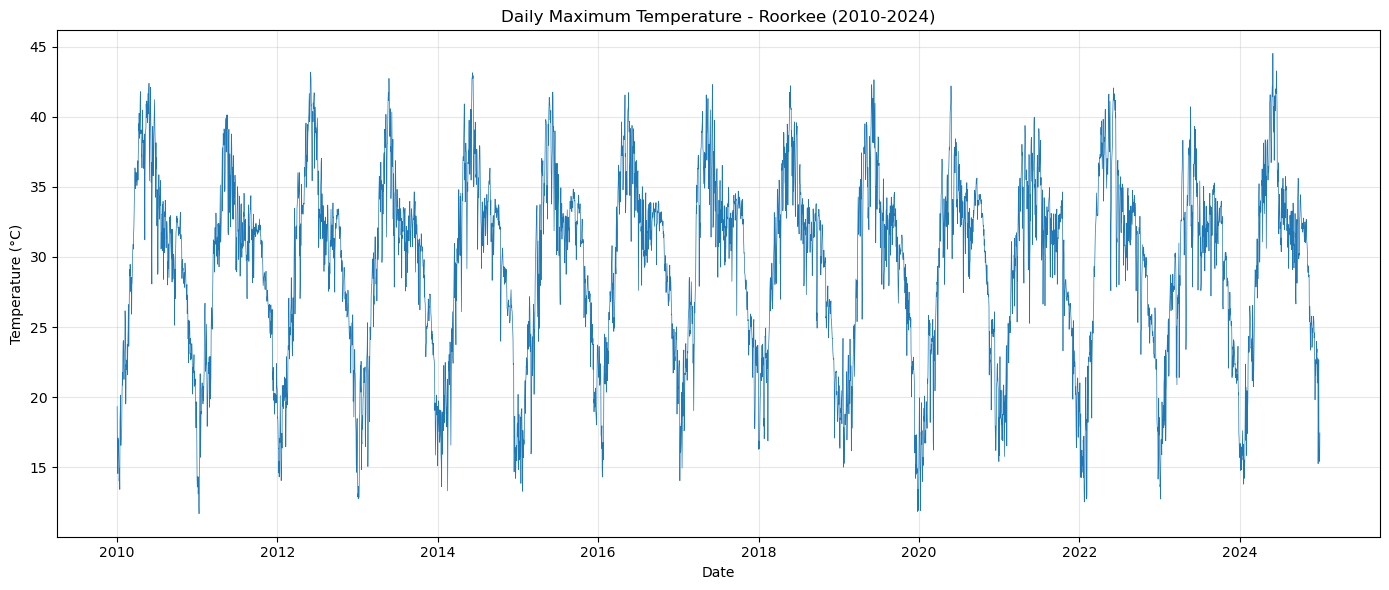

<Figure size 1200x600 with 0 Axes>

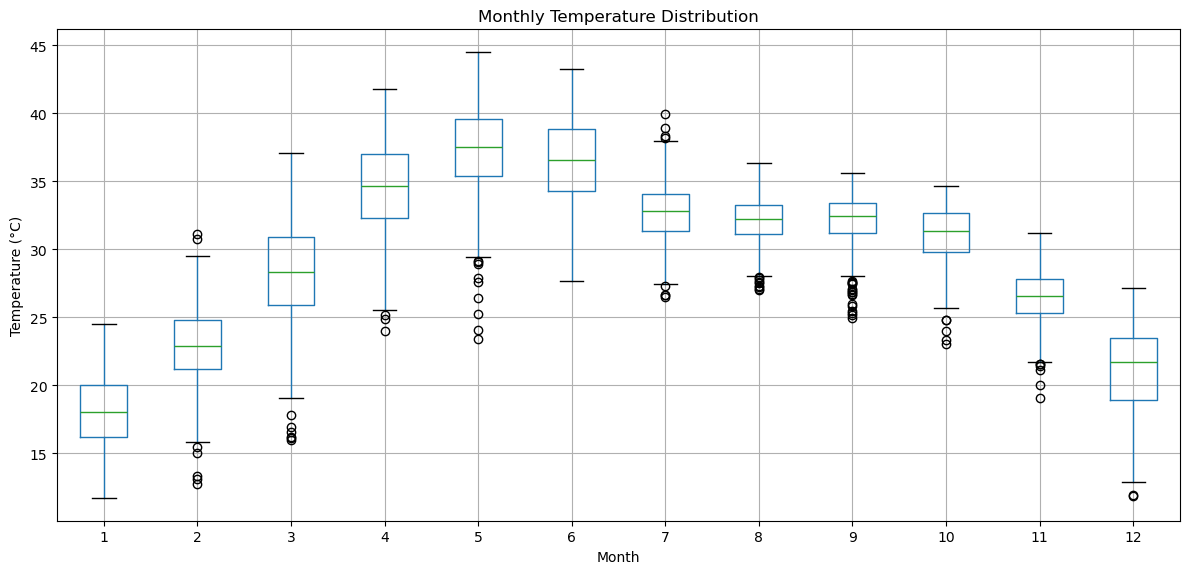

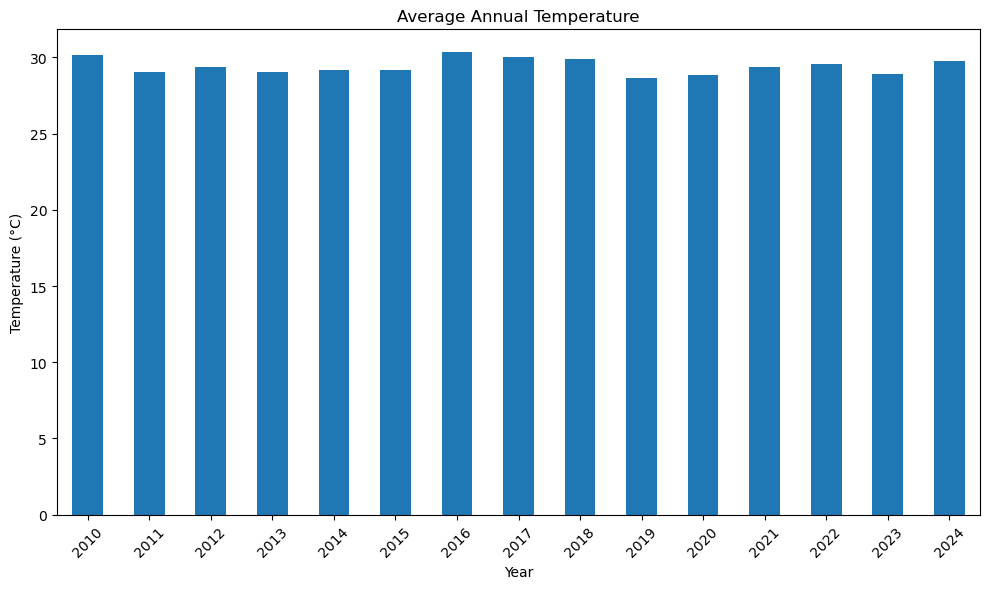

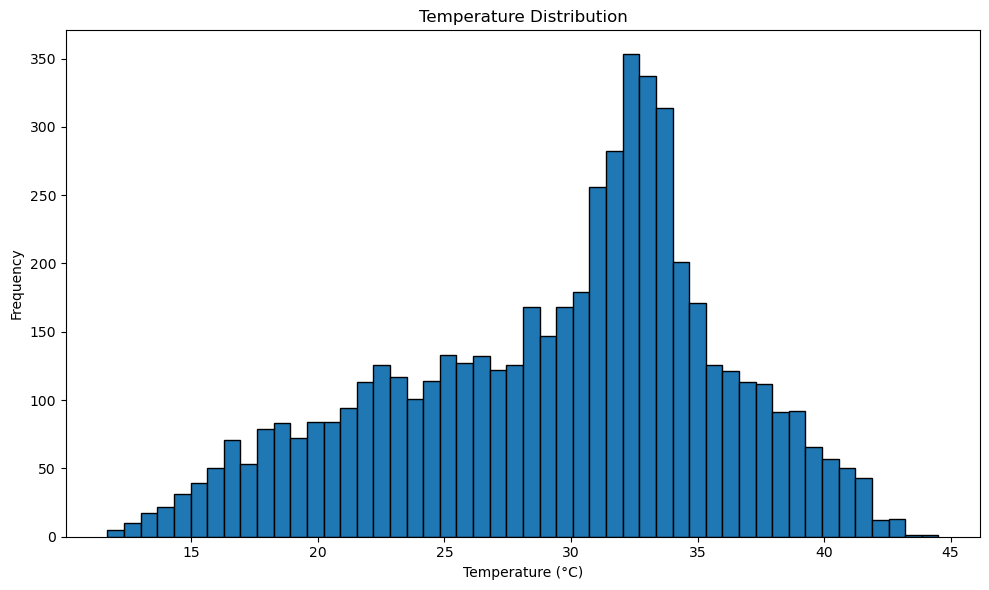

In [35]:
#EDA
# 1) Time series plot
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['tmax'], linewidth=0.5)
plt.title('Daily Maximum Temperature - Roorkee (2010-2024)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('tmax_timeseries_plot.png', dpi=300)
plt.show()

# 2) Monthly boxplot to see seasonality
df['month'] = df.index.month
plt.figure(figsize=(12, 6))
df.boxplot(column='tmax', by='month', figsize=(12, 6))
plt.title('Monthly Temperature Distribution')
plt.suptitle('')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.tight_layout()
plt.savefig('tmax_monthly_boxplot.png', dpi=300)
plt.show()

# 3) Yearly trend
df['year'] = df.index.year
yearly_avg = df.groupby('year')['tmax'].mean()
plt.figure(figsize=(10, 6))
yearly_avg.plot(kind='bar')
plt.title('Average Annual Temperature')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('tmax_yearly_trend.png', dpi=300)
plt.show()

# 4) Distribution histogram
plt.figure(figsize=(10, 6))
plt.hist(df['tmax'], bins=50, edgecolor='black')
plt.title('Temperature Distribution')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig('temperature_distribution.png', dpi=300)
plt.show()


In [9]:
# Splitting data set for training, validation and testing (chronologically)
# Split Proportions : 70% train, 15% validation, 15% test

n = len(df)
train_size = int(0.70 * n)
val_size = int(0.15 * n)

# Split chronologically (as it is TIME series data)
train = df.iloc[:train_size]
validation = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

print(f"Training set: {train.index[0]} to {train.index[-1]} ({len(train)} samples)")
print(f"Validation set: {validation.index[0]} to {validation.index[-1]} ({len(validation)} samples)")
print(f"Test set: {test.index[0]} to {test.index[-1]} ({len(test)} samples)")

# Save splits
train.to_csv('train_data.csv')
validation.to_csv('validation_data.csv')
test.to_csv('test_data.csv')


Training set: 2010-01-01 00:00:00 to 2020-07-01 00:00:00 (3835 samples)
Validation set: 2020-07-02 00:00:00 to 2022-09-30 00:00:00 (821 samples)
Test set: 2022-10-01 00:00:00 to 2024-12-31 00:00:00 (823 samples)


In [10]:
# Feature Engineering
def create_features(df):
    # Creating features for temperature prediction
    df = df.copy()
    
    # Date-based features
    df['day_of_year'] = df.index.dayofyear
    df['month'] = df.index.month
    df['day'] = df.index.day
    
    # Cyclical encoding for seasonality
    df['sin_doy'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['cos_doy'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # Lag features (previous days)
    df['lag1'] = df['tmax'].shift(1)  # yesterday
    df['lag2'] = df['tmax'].shift(2)  # 2 days ago
    df['lag3'] = df['tmax'].shift(3)  # 3 days ago
    df['lag7'] = df['tmax'].shift(7)  # last week
    
    # Rolling statistics
    df['rolling_mean_7'] = df['tmax'].rolling(window=7).mean()
    df['rolling_std_7'] = df['tmax'].rolling(window=7).std()
    
    # Drop rows with NaN created by lag/rolling
    df = df.dropna()
    
    return df

# Apply to all splits
train_feat = create_features(train)
val_feat = create_features(validation)
test_feat = create_features(test)

print("Features created:")
print(train_feat.columns.tolist())


Features created:
['tmax', 'lat', 'lon', 'month', 'year', 'day_of_year', 'day', 'sin_doy', 'cos_doy', 'lag1', 'lag2', 'lag3', 'lag7', 'rolling_mean_7', 'rolling_std_7']


=== Climatology Baseline Model Performance ===
Sample predictions vs actual:
            Actual Temp  Climatology Prediction
time                                           
2022-10-01    31.653530               32.335792
2022-10-02    31.987095               32.655936
2022-10-03    32.902790               32.403847
2022-10-04    32.884090               32.104571
2022-10-05    31.860682               32.668251
2022-10-06    29.255342               32.448816
2022-10-07    26.591646               32.185567
2022-10-08    23.044687               32.244820
2022-10-09    24.765266               32.189131
2022-10-10    24.806402               32.201979
RMSE: 2.674 °C
MAE: 2.022 °C
R²: 0.8200


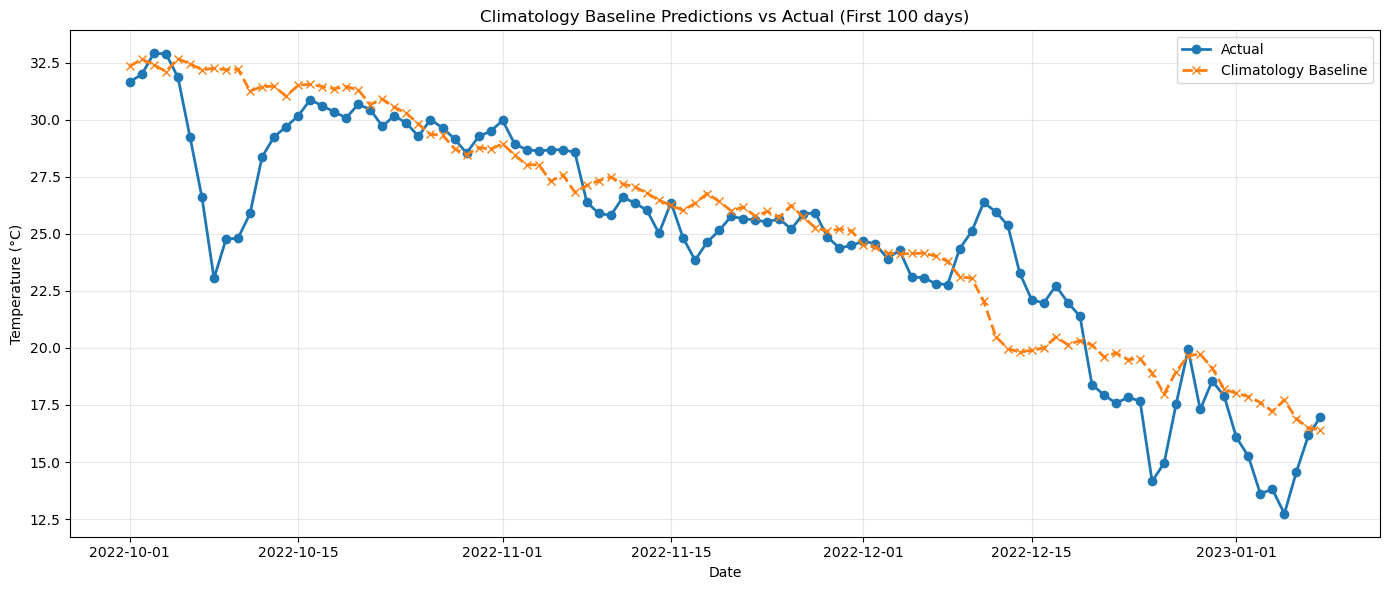

In [12]:
# Climatology Baseline Model

print("=== Climatology Baseline Model Performance ===")

# Calculate climatological average for each day of year
climatology = train['tmax'].groupby(train.index.dayofyear).mean()

# Predict on test set using climatology
test_with_pred = test.copy()
test_with_pred['doy'] = test_with_pred.index.dayofyear
test_with_pred['climatology_pred'] = test_with_pred['doy'].map(climatology)

#Showing some predictions
print("Sample predictions vs actual:")
sample = test_with_pred[['tmax', 'climatology_pred']].head(10)
sample.columns = ['Actual Temp', 'Climatology Prediction']
print(sample)

# Evaluate
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse_baseline = np.sqrt(mean_squared_error(test_with_pred['tmax'], test_with_pred['climatology_pred']))
mae_baseline = mean_absolute_error(test_with_pred['tmax'], test_with_pred['climatology_pred'])
r2_baseline = r2_score(test_with_pred['tmax'], test_with_pred['climatology_pred'])

print(f"RMSE: {rmse_baseline:.3f} °C")
print(f"MAE: {mae_baseline:.3f} °C")
print(f"R²: {r2_baseline:.4f}")

# Save baseline predictions
test_with_pred.to_csv('baseline_predictions.csv')

# Visualize predictions
plt.figure(figsize=(14, 6))
plt.plot(test_with_pred.index[:100], test_with_pred['tmax'][:100], label='Actual', marker='o', linewidth=2)
plt.plot(test_with_pred.index[:100], test_with_pred['climatology_pred'][:100], label='Climatology Baseline',
         marker='x', linewidth=2, linestyle='--')
plt.title('Climatology Baseline Predictions vs Actual (First 100 days)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('baseline_predictions_plot.png', dpi=300)
plt.show()


=== Linear Regression Performance ===
      Date  Actual (°C)  Predicted (°C)
2022-10-08    23.044687       26.482996
2022-10-09    24.765266       24.691753
2022-10-10    24.806402       25.950347
2022-10-11    25.892624       25.844529
2022-10-12    28.367495       25.630424
2022-10-13    29.246019       27.141518
2022-10-14    29.692421       27.537480
2022-10-15    30.164225       28.379462
2022-10-16    30.871475       28.956899
2022-10-17    30.605007       30.057529
2022-10-18    30.333406       30.249741
2022-10-19    30.080418       29.885315
2022-10-20    30.674526       29.995479
2022-10-21    30.436508       30.535900
2022-10-22    29.705563       30.207353
RMSE: 1.432 °C
MAE: 1.057 °C
R²: 0.9487


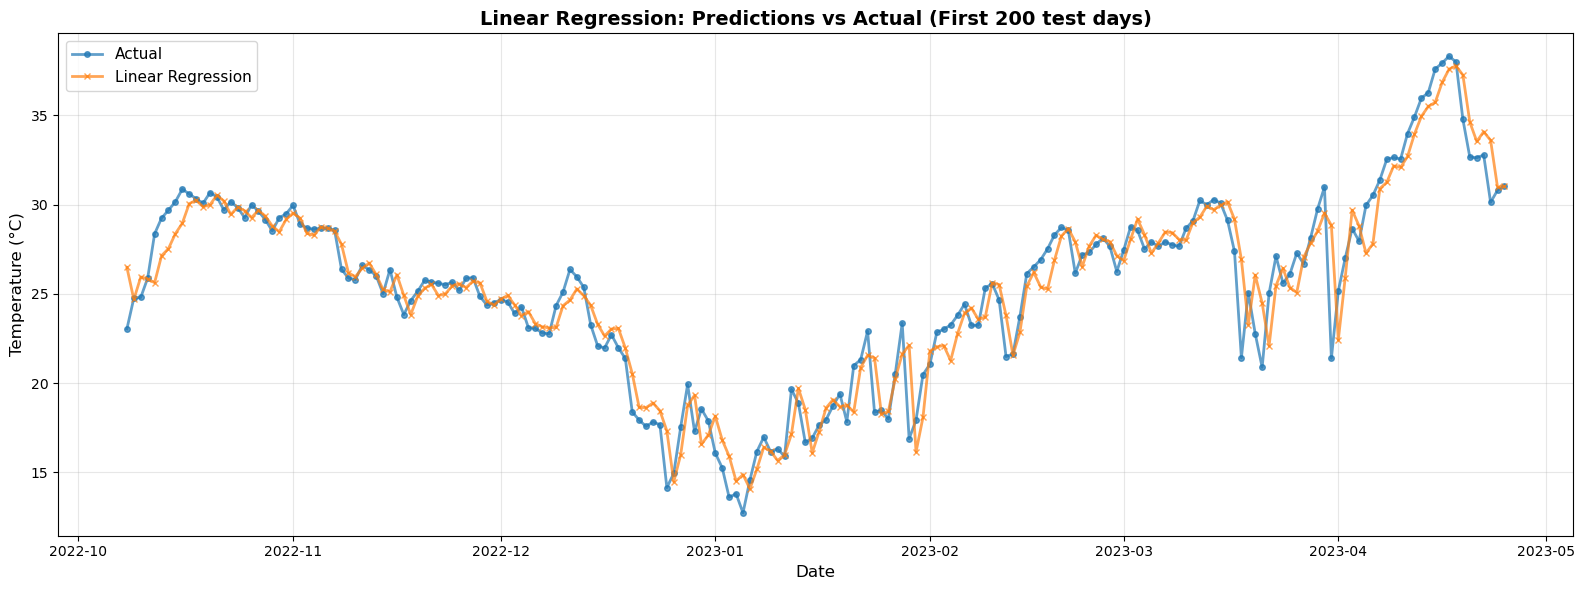

In [14]:
# Linear Regression Model

print("=== Linear Regression Performance ===")

from sklearn.linear_model import LinearRegression

# Define features and target
feature_cols = ['sin_doy', 'cos_doy', 'lag1', 'lag2', 'lag3', 'lag7', 'rolling_mean_7', 'rolling_std_7']
target_col = 'tmax'

X_train = train_feat[feature_cols]
y_train = train_feat[target_col]

X_val = val_feat[feature_cols]
y_val = val_feat[target_col]

X_test = test_feat[feature_cols]
y_test = test_feat[target_col]

# Train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict
y_pred_train = lr_model.predict(X_train)
y_pred_val = lr_model.predict(X_val)
y_pred_test = lr_model.predict(X_test)

# Displaying some predicted values vs actual values
sample_results = pd.DataFrame({
    'Date': test_feat.index[:15],
    'Actual (°C)': y_test.values[:15],
    'Predicted (°C)': y_pred_test[:15]
})

# sample_results['Error (°C)'] = sample_results['Error (°C)'].round(2)
# sample_results['Predicted (°C)'] = sample_results['Predicted (°C)'].round(2)
print(sample_results.to_string(index=False))

# Evaluating on test dataset
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_lr = mean_absolute_error(y_test, y_pred_test)
r2_lr = r2_score(y_test, y_pred_test)

print(f"RMSE: {rmse_lr:.3f} °C")
print(f"MAE: {mae_lr:.3f} °C")
print(f"R²: {r2_lr:.4f}")

# Test predictions
test_results = test_feat.copy()
test_results['predicted_tmax'] = y_pred_test
test_results['prediction_error'] = test_results['tmax'] - test_results['predicted_tmax']
test_results.to_csv('linear_regression_test_predictions.csv')


# Plotting Predictions vs Actual (Time Series)
fig, ax = plt.subplots(figsize=(16, 6))
n_display = 200  # Show first 200 days
ax.plot(test_feat.index[:n_display], y_test.values[:n_display], label='Actual', marker='o', linewidth=2,
                markersize=4, alpha=0.7)
ax.plot(test_feat.index[:n_display], y_pred_test[:n_display], label='Linear Regression', marker='x', linewidth=2,
                markersize=4, alpha=0.7)
ax.set_title(f'Linear Regression: Predictions vs Actual (First {n_display} test days)', fontsize=14,
                fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('lr_predictions_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()



Sample comparison of both models (First 10 days):
            Actual  Baseline  Linear Regression
time                                           
2022-10-08   23.04     32.24              26.48
2022-10-09   24.77     32.19              24.69
2022-10-10   24.81     32.20              25.95
2022-10-11   25.89     31.25              25.84
2022-10-12   28.37     31.45              25.63
2022-10-13   29.25     31.46              27.14
2022-10-14   29.69     31.02              27.54
2022-10-15   30.16     31.51              28.38
2022-10-16   30.87     31.54              28.96
2022-10-17   30.61     31.45              30.06

Performance Comparison
               Model  RMSE (°C)  MAE (°C)       R²
Climatology Baseline   2.674402  2.022305 0.819986
   Linear Regression   1.432333  1.056501 0.948705

✓ Linear Regression improves RMSE by 46.4%
✓ Linear Regression improves MAE by 47.8%
✓ Linear Regression improves R2 by 15.7%

Showing Plot


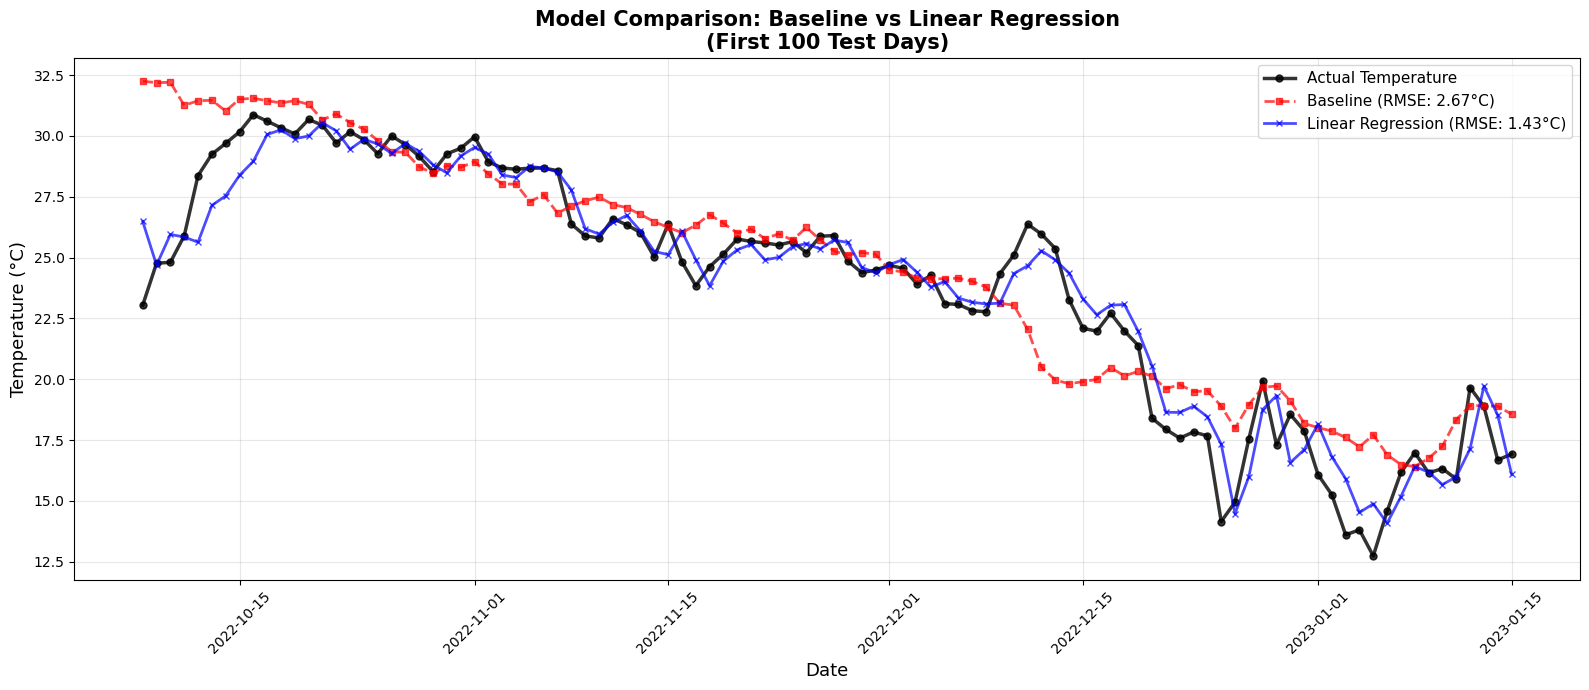

✓ Plot saved to 'model_comparison_timeseries.png'


In [51]:
# Comparison & Visualisation


# First, we need to align the data since test_feat (with features) is shorter than test
# We'll use test_feat as the reference since it has both models' predictions

# Get climatology predictions for the same dates as test_feat
test_feat_with_both = test_feat.copy()
test_feat_with_both['doy'] = test_feat_with_both.index.dayofyear
test_feat_with_both['baseline_pred'] = test_feat_with_both['doy'].map(climatology)
test_feat_with_both['lr_pred'] = y_pred_test
test_feat_with_both['actual'] = y_test.values

# Display sample comparison
print("\nSample comparison of both models (First 10 days):")
sample_comparison = test_feat_with_both[['actual', 'baseline_pred', 'lr_pred']].head(10)
sample_comparison.columns = ['Actual', 'Baseline', 'Linear Regression']
sample_comparison = sample_comparison.round(2)
print(sample_comparison.to_string())


# Print comparison
print("\nPerformance Comparison")
comparison_df = pd.DataFrame({'Model': ['Climatology Baseline', 'Linear Regression'],
    'RMSE (°C)': [rmse_baseline, rmse_lr], 'MAE (°C)': [mae_baseline, mae_lr], 'R²': [r2_baseline, r2_lr]
})
print(comparison_df.to_string(index=False))

# Calculate improvement
rmse_improvement = ((rmse_baseline - rmse_lr) / rmse_baseline) * 100
mae_improvement = ((mae_baseline - mae_lr) / mae_baseline) * 100
r2_improvement = ((r2_lr - r2_baseline) / r2_baseline) * 100
print(f"\n✓ Linear Regression improves RMSE by {rmse_improvement:.1f}%")
print(f"✓ Linear Regression improves MAE by {mae_improvement:.1f}%")
print(f"✓ Linear Regression improves R2 by {r2_improvement:.1f}%")

# Save comparison data
test_feat_with_both[['actual', 'baseline_pred', 'lr_pred']].to_csv('model_comparison_predictions.csv')

# VISUALIZATION 1: Time Series Comparison (First 100 days)
print("\nShowing Plot")
n_display = 100

fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(test_feat_with_both.index[:n_display], test_feat_with_both['actual'][:n_display], 
        label='Actual Temperature', linewidth=2.5, marker='o', markersize=5, color='black', alpha=0.8)
ax.plot(test_feat_with_both.index[:n_display], test_feat_with_both['baseline_pred'][:n_display], 
        label=f'Baseline (RMSE: {rmse_baseline:.2f}°C)', linewidth=2, marker='s', markersize=4, linestyle='--',
        color='red', alpha=0.7)
ax.plot(test_feat_with_both.index[:n_display], test_feat_with_both['lr_pred'][:n_display],
        label=f'Linear Regression (RMSE: {rmse_lr:.2f}°C)', linewidth=2, marker='x', markersize=5, color='blue',
        alpha=0.7)

ax.set_title('Model Comparison: Baseline vs Linear Regression\n(First 100 Test Days)', fontsize=15,
             fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Temperature (°C)', fontsize=13)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('model_comparison_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot saved to 'model_comparison_timeseries.png'")


In [49]:
## TEMPERATURE PREDICTION LOOKUP TOOL
# For dates in test period: Oct 8, 2022 to Dec 31, 2024

from datetime import datetime

print("TEMPERATURE PREDICTION LOOKUP SYSTEM")
print("Available date range: 2022-10-08 to 2024-12-31 (YYYY-MM-DD format)")

# Load the test predictions CSV file
test_predictions = pd.read_csv('linear_regression_test_predictions.csv', index_col=0, parse_dates=True)

def get_prediction(date_input):
    """
    Gets temperature prediction for a specific date
    Parameters:
    date_input : str
    Date in format 'YYYY-MM-DD' (e.g., '2023-10-30')
    Prints prediction value along with prediction details
    """
    try:
        # Convert input to datetime
        target_date = pd.to_datetime(date_input)
        
        # Check if date is in range
        if target_date not in test_predictions.index:
            # Check if it's before or after the range
            if target_date < test_predictions.index[0]:
                print(f"\n❌ Error: Date {target_date.date()} is before test period")
                print(f"   Test period starts: {test_predictions.index[0].date()}")
            elif target_date > test_predictions.index[-1]:
                print(f"\n❌ Error: Date {target_date.date()} is after test period")
                print(f"   Test period ends: {test_predictions.index[-1].date()}")
            else:
                print(f"\n❌ Error: Date {target_date.date()} not found in test data")
            return None
        
        # Get the data for this date
        data = test_predictions.loc[target_date]
        
        # Display results
        print(f"📅 Date: {target_date.strftime('%A, %B %d, %Y')}")
        print(f"🌡️ Predicted Temperature:  {data['predicted_tmax']:.2f}°C", end = ' ')
        print(f"with an error of {data['prediction_error']:.2f}°C")

        # Show accuracy assessment
        error = abs(data['prediction_error'])
        if error < 1.0:
            accuracy = "Excellent (< 1°C)"
        elif error < 2.0:
            accuracy = "Very Good (< 2°C)"
        elif error < 3.0:
            accuracy = "Good (< 3°C)"
        else:
            accuracy = "Fair (≥ 3°C)"
        print(f"🎯 Accuracy Rating:        {accuracy}")
                
    except Exception as e:
        print(f"\n❌ Error: {e}")
        print("Please use date format: YYYY-MM-DD (e.g., '2023-10-30')")
        return None


# User's part starts from here
print("Enter the date in YYYY-MM-DD in format for which you would like to see the predicted maximum temperature : ")
date = input()
get_prediction(date)


TEMPERATURE PREDICTION LOOKUP SYSTEM
Available date range: 2022-10-08 to 2024-12-31 (YYYY-MM-DD format)
Enter the date in YYYY-MM-DD in format for which you would like to see the predicted maximum temperature : 


 2024-11-10


📅 Date: Sunday, November 10, 2024
🌡️ Predicted Temperature:  28.41°C with an error of 0.16°C
🎯 Accuracy Rating:        Excellent (< 1°C)


In [32]:
dr = pd.read_csv('Rainfall_Roorkee_2010_2024.csv', index_col=0, parse_dates=True)
print("\nMissing Values in Rainfall Data:")
print(dr.isnull().sum())



Missing Values in Rainfall Data:
rain    0
lat     0
lon     0
dtype: int64


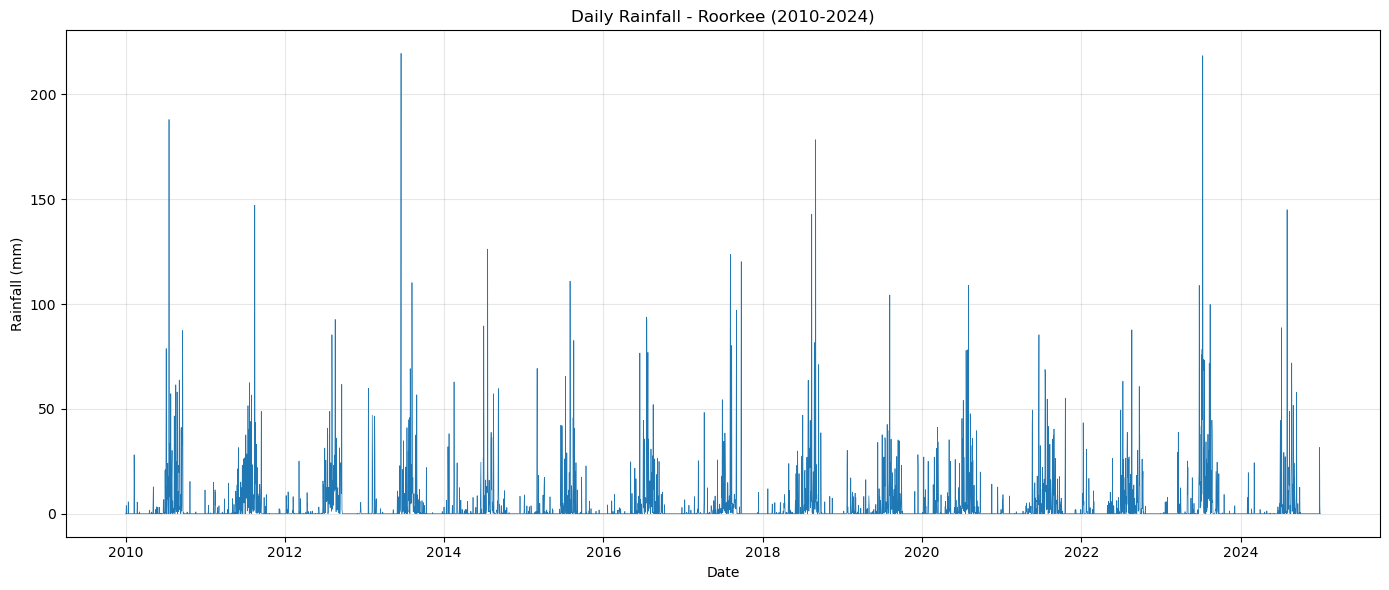

In [50]:
plt.figure(figsize=(14, 6))
plt.plot(dr.index, dr['rain'], linewidth=0.5)
plt.title('Daily Rainfall - Roorkee (2010-2024)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rain_timeseries_plot.png', dpi=300)
plt.show()


In [41]:
# Splitting data set for training, validation and testing (chronologically)
# Split Proportions : 70% train, 15% validation, 15% test

rain_n = len(dr)
rain_train_size = int(0.70 * rain_n)
rain_val_size = int(0.15 * rain_n)

# Split chronologically (as it is TIME series data)
rain_train = dr.iloc[:rain_train_size]
rain_validate = dr.iloc[rain_train_size:rain_train_size+rain_val_size]
rain_test = dr.iloc[rain_train_size+rain_val_size:]

print(f"Training set for rainfall: {rain_train.index[0]} to {rain_train.index[-1]} ({len(rain_train)} samples)")
print(f"Validation set for rainfall: {rain_validate.index[0]} to {rain_validate.index[-1]} ({len(rain_validate)} samples)")
print(f"Testing set for rainfall: {rain_test.index[0]} to {rain_test.index[-1]} ({len(rain_test)} samples)")

# Save splits
rain_train.to_csv('rain_train_data.csv')
rain_validate.to_csv('rain_validate_data.csv')
rain_test.to_csv('rain_test_data.csv')


Training set for rainfall: 2010-01-01 00:00:00 to 2020-07-01 00:00:00 (3835 samples)
Validation set for rainfall: 2020-07-02 00:00:00 to 2022-09-30 00:00:00 (821 samples)
Testing set for rainfall: 2022-10-01 00:00:00 to 2024-12-31 00:00:00 (823 samples)


In [42]:
# Feature Engineering
def create_features(dr):
    # Creating features for rainfall prediction
    dr = dr.copy()
    
    # Date-based features
    dr['day_of_year'] = dr.index.dayofyear
    dr['month'] = dr.index.month
    dr['day'] = dr.index.day
    
    # Cyclical encoding for seasonality
    dr['sin_doy'] = np.sin(2 * np.pi * dr['day_of_year'] / 365)
    dr['cos_doy'] = np.cos(2 * np.pi * dr['day_of_year'] / 365)
    
    # Lag features (previous days)
    dr['lag1'] = dr['rain'].shift(1)  # yesterday
    dr['lag2'] = dr['rain'].shift(2)  # 2 days ago
    dr['lag3'] = dr['rain'].shift(3)  # 3 days ago
    dr['lag7'] = dr['rain'].shift(7)  # last week
    
    # Rolling statistics
    dr['rolling_mean_7'] = dr['rain'].rolling(window=7).mean()
    dr['rolling_std_7'] = dr['rain'].rolling(window=7).std()
    
    # Drop rows with NaN created by lag/rolling
    dr = dr.dropna()
    
    return dr

# Apply to all splits
rain_train_feat = create_features(rain_train)
rain_val_feat = create_features(rain_validate)
rain_test_feat = create_features(rain_test)

print("Features created:")
print(rain_train_feat.columns.tolist())


Features created:
['rain', 'lat', 'lon', 'day_of_year', 'month', 'day', 'sin_doy', 'cos_doy', 'lag1', 'lag2', 'lag3', 'lag7', 'rolling_mean_7', 'rolling_std_7']


=== Climatology Baseline Model Performance for Rain===
Sample predictions vs actual:
            Actual Rainfall  Climatology Prediction
time                                               
2022-10-01         0.000000                1.113956
2022-10-02         2.385829                0.219835
2022-10-03         0.000000                0.010459
2022-10-04         0.000000                1.100493
2022-10-05         0.191867                0.354579
2022-10-06        26.074360                0.000000
2022-10-07         3.408393                0.057719
2022-10-08         2.531001                1.364646
2022-10-09        15.629926                0.162853
2022-10-10        20.226414                0.083936
RMSE: 14.107 mm
MAE: 5.288 mm
R²: 0.1000


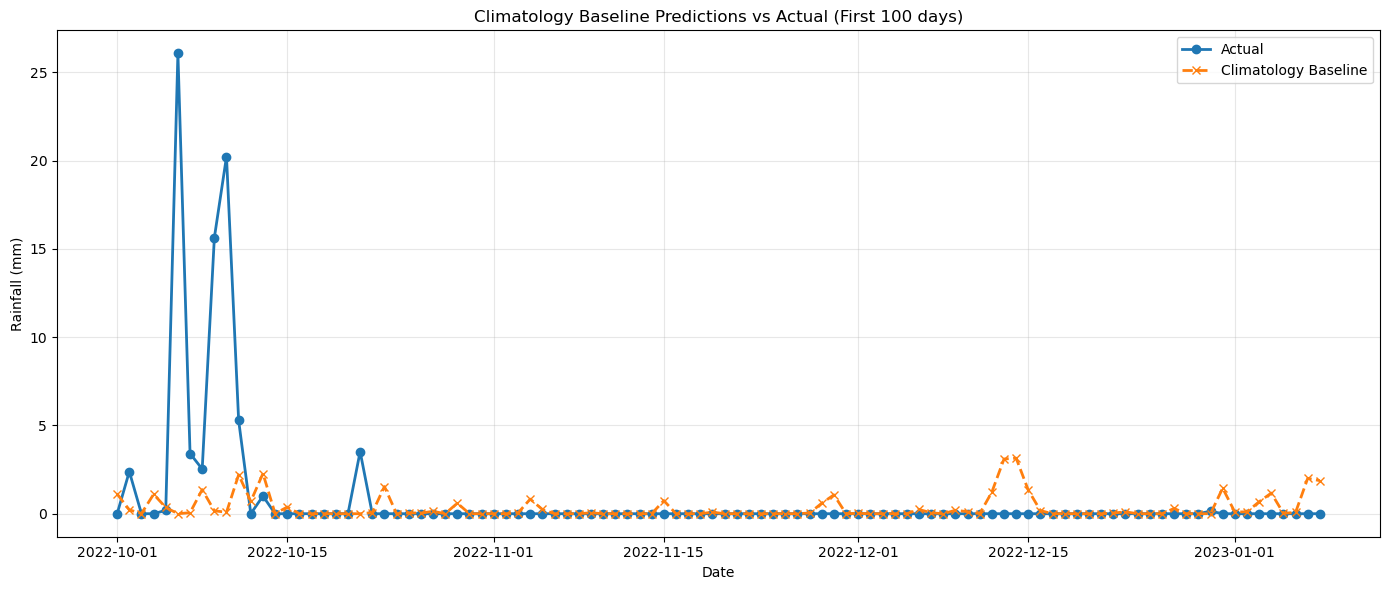

In [43]:
# Climatology Baseline Model

print("=== Climatology Baseline Model Performance for Rain===")

# Calculate climatological average for each day of year
rain_climatology = rain_train['rain'].groupby(rain_train.index.dayofyear).mean()

# Predict on test set using climatology
rain_test_with_pred = rain_test.copy()
rain_test_with_pred['doy'] = rain_test_with_pred.index.dayofyear
rain_test_with_pred['rain_climatology_pred'] = rain_test_with_pred['doy'].map(rain_climatology)

#Showing some predictions
print("Sample predictions vs actual:")
rain_sample = rain_test_with_pred[['rain', 'rain_climatology_pred']].head(10)
rain_sample.columns = ['Actual Rainfall', 'Climatology Prediction']
print(rain_sample)

# Evaluate

rain_rmse_baseline = np.sqrt(mean_squared_error(rain_test_with_pred['rain'], rain_test_with_pred['rain_climatology_pred']))
rain_mae_baseline = mean_absolute_error(rain_test_with_pred['rain'], rain_test_with_pred['rain_climatology_pred'])
rain_r2_baseline = r2_score(rain_test_with_pred['rain'], rain_test_with_pred['rain_climatology_pred'])

print(f"RMSE: {rain_rmse_baseline:.3f} mm")
print(f"MAE: {rain_mae_baseline:.3f} mm")
print(f"R²: {rain_r2_baseline:.4f}")

# Save baseline predictions
rain_test_with_pred.to_csv('rain_baseline_predictions.csv')

# Visualize predictions
plt.figure(figsize=(14, 6))
plt.plot(rain_test_with_pred.index[:100], rain_test_with_pred['rain'][:100], label='Actual', marker='o', linewidth=2)
plt.plot(rain_test_with_pred.index[:100], rain_test_with_pred['rain_climatology_pred'][:100], label='Climatology Baseline',
         marker='x', linewidth=2, linestyle='--')
plt.title('Climatology Baseline Predictions vs Actual (First 100 days)')
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rain_baseline_predictions_plot.png', dpi=300)
plt.show()


=== Linear Regression Performance ===
      Date  Actual (mm)  Predicted (mm)
2022-10-08     2.531001        1.299140
2022-10-09    15.629926        2.379345
2022-10-10    20.226414       13.179729
2022-10-11     5.280066       11.698155
2022-10-12     0.000000        6.813162
2022-10-13     1.001047        2.282797
2022-10-14     0.000000        7.822724
2022-10-15     0.000000        8.421306
2022-10-16     0.000000        4.408902
2022-10-17     0.000000        0.394999
2022-10-18     0.000000        0.134869
2022-10-19     0.000000        0.405767
2022-10-20     0.000000        0.150885
2022-10-21     3.520044        0.876386
2022-10-22     0.000000        0.959909
RMSE: 11.776 mm
MAE: 4.236 mm
R²: 0.3763


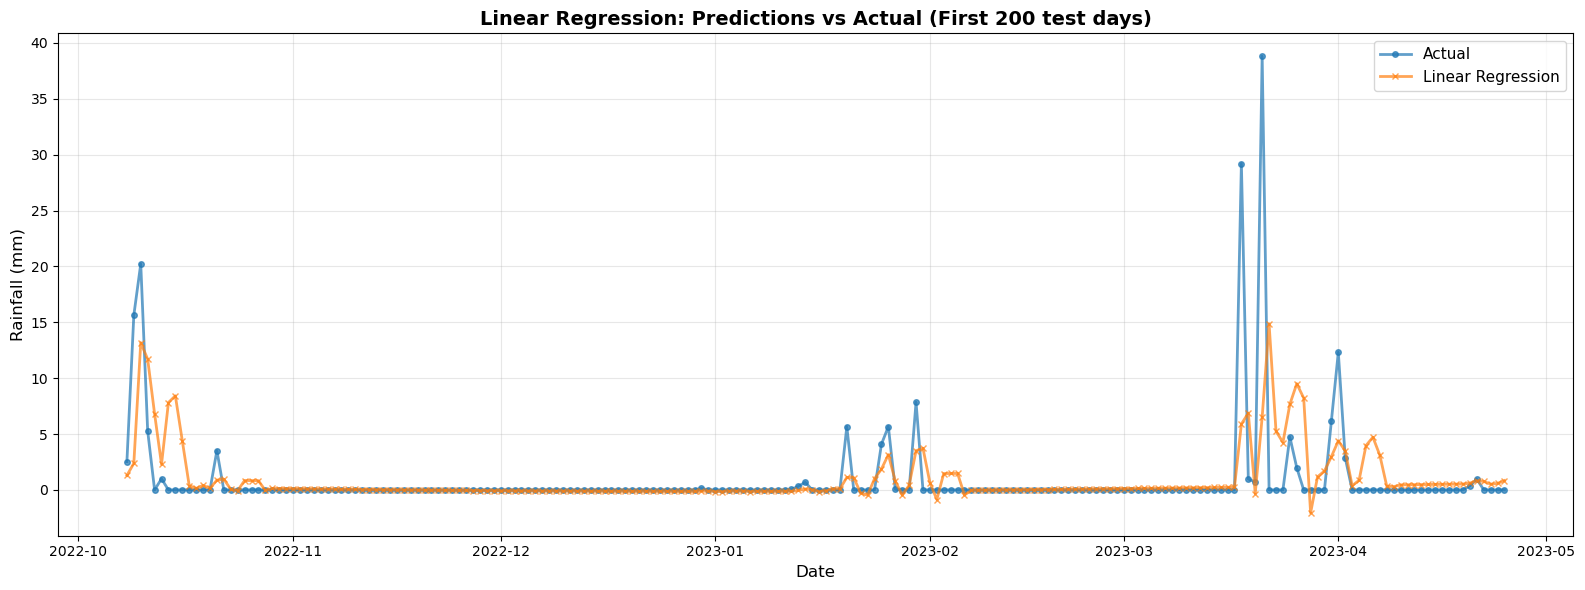

In [44]:
# Linear Regression Model

print("=== Linear Regression Performance ===")

# Define features and target
rain_feature_cols = ['sin_doy', 'cos_doy', 'lag1', 'lag2', 'lag3', 'lag7', 'rolling_mean_7', 'rolling_std_7']
rain_target_col = 'rain'

X_rain_train = rain_train_feat[rain_feature_cols]
y_rain_train = rain_train_feat[rain_target_col]

X_rain_val = rain_val_feat[rain_feature_cols]
y_rain_val = rain_val_feat[rain_target_col]

X_rain_test = rain_test_feat[rain_feature_cols]
y_rain_test = rain_test_feat[rain_target_col]

# Train model
lr_rain_model = LinearRegression()
lr_rain_model.fit(X_rain_train, y_rain_train)

# Predict
y_rain_pred_train = lr_rain_model.predict(X_rain_train)
y_rain_pred_val = lr_rain_model.predict(X_rain_val)
y_rain_pred_test = lr_rain_model.predict(X_rain_test)

# Displaying some predicted values vs actual values
rain_sample_results = pd.DataFrame({
    'Date': rain_test_feat.index[:15],
    'Actual (mm)': y_rain_test.values[:15],
    'Predicted (mm)': y_rain_pred_test[:15]
})

# sample_results['Error (mm)'] = sample_results['Error (mm)'].round(2)
# sample_results['Predicted (mm)'] = sample_results['Predicted (mm)'].round(2)
print(rain_sample_results.to_string(index=False))

# Evaluating on test dataset
rain_rmse_lr = np.sqrt(mean_squared_error(y_rain_test, y_rain_pred_test))
rain_mae_lr = mean_absolute_error(y_rain_test, y_rain_pred_test)
rain_r2_lr = r2_score(y_rain_test, y_rain_pred_test)

print(f"RMSE: {rain_rmse_lr:.3f} mm")
print(f"MAE: {rain_mae_lr:.3f} mm")
print(f"R²: {rain_r2_lr:.4f}")

# Test predictions
rain_test_results = rain_test_feat.copy()
rain_test_results['predicted_rain'] = y_rain_pred_test
rain_test_results['prediction_error'] = rain_test_results['rain'] - rain_test_results['predicted_rain']
rain_test_results.to_csv('rain_linear_regression_test_predictions.csv')


# Plotting Predictions vs Actual (Time Series)
fig, ax = plt.subplots(figsize=(16, 6))
n_display = 200  # Show first 200 days
ax.plot(rain_test_feat.index[:n_display], y_rain_test.values[:n_display], label='Actual', marker='o', linewidth=2,
                markersize=4, alpha=0.7)
ax.plot(rain_test_feat.index[:n_display], y_rain_pred_test[:n_display], label='Linear Regression', marker='x',
        linewidth=2, markersize=4, alpha=0.7)
ax.set_title(f'Linear Regression: Predictions vs Actual (First {n_display} test days)', fontsize=14,
                fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rainfall (mm)', fontsize=12)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rain_lr_predictions_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()



Sample comparison of both models (First 10 days):
            Actual  Baseline  Linear Regression
time                                           
2022-10-08    2.53      1.36               1.30
2022-10-09   15.63      0.16               2.38
2022-10-10   20.23      0.08              13.18
2022-10-11    5.28      2.20              11.70
2022-10-12    0.00      0.70               6.81
2022-10-13    1.00      2.28               2.28
2022-10-14    0.00      0.01               7.82
2022-10-15    0.00      0.38               8.42
2022-10-16    0.00      0.00               4.41
2022-10-17    0.00      0.00               0.39

Performance Comparison
               Model  RMSE (mm)  MAE (mm)       R²
Climatology Baseline  14.107256  5.287964 0.100044
   Linear Regression  11.776224  4.236367 0.376327

✓ Linear Regression improves RMSE by 16.5%
✓ Linear Regression improves MAE by 19.9%

Showing Plot


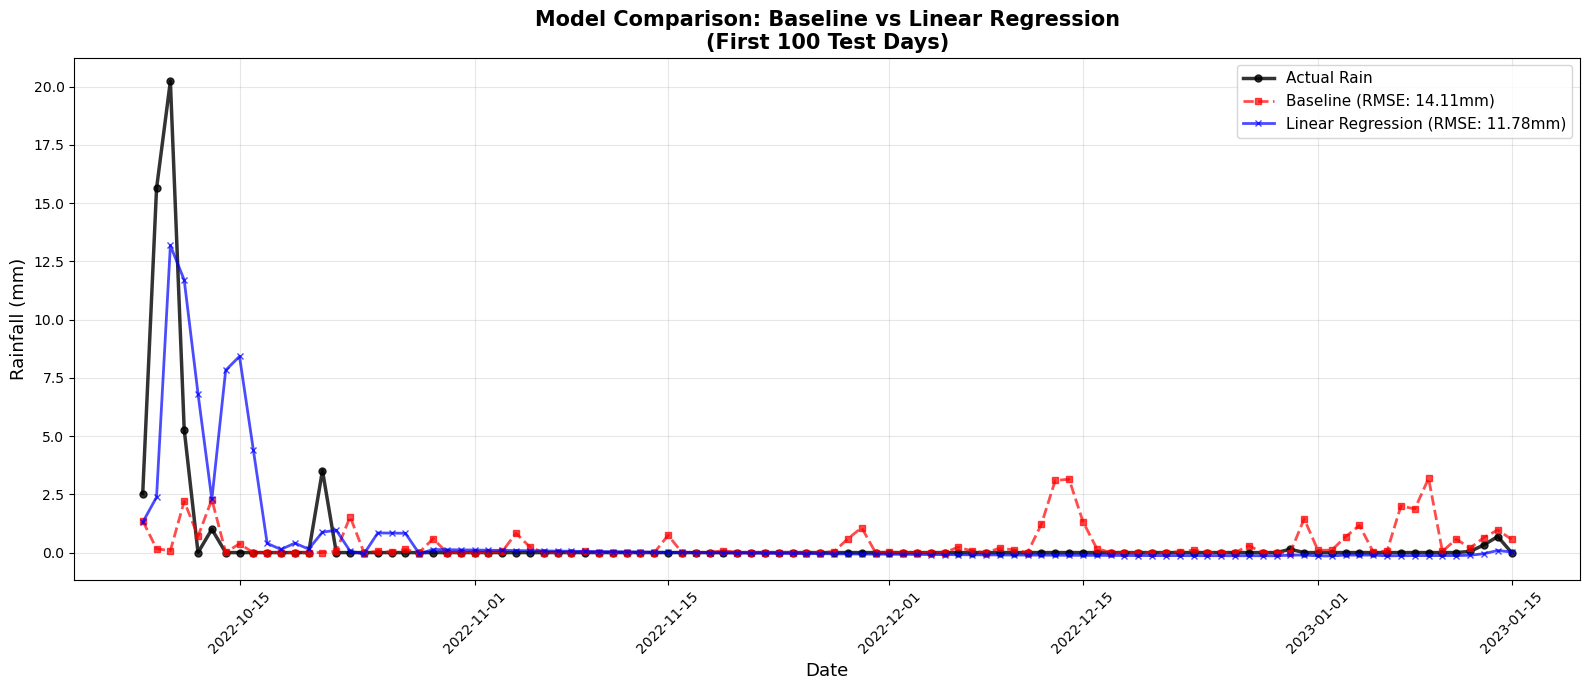

✓ Plot saved to 'rain_model_comparison_timeseries.png'


In [45]:
# Comparison & Visualisation


# First, we need to align the data since rain_test_feat (with features) is shorter than test
# We'll use rain_test_feat as the reference since it has both models' predictions

# Get climatology predictions for the same dates as rain_test_feat
rain_test_feat_with_both = rain_test_feat.copy()
rain_test_feat_with_both['doy'] = rain_test_feat_with_both.index.dayofyear
rain_test_feat_with_both['baseline_pred'] = rain_test_feat_with_both['doy'].map(rain_climatology)
rain_test_feat_with_both['lr_pred'] = y_rain_pred_test
rain_test_feat_with_both['actual'] = y_rain_test.values

# Display sample comparison
print("\nSample comparison of both models (First 10 days):")
rain_sample_comparison = rain_test_feat_with_both[['actual', 'baseline_pred', 'lr_pred']].head(10)
rain_sample_comparison.columns = ['Actual', 'Baseline', 'Linear Regression']
rain_sample_comparison = rain_sample_comparison.round(2)
print(rain_sample_comparison.to_string())


# Print comparison
print("\nPerformance Comparison")
rain_comparison_dr = pd.DataFrame({'Model': ['Climatology Baseline', 'Linear Regression'],
    'RMSE (mm)': [rain_rmse_baseline, rain_rmse_lr], 'MAE (mm)': [rain_mae_baseline, rain_mae_lr],
    'R²': [rain_r2_baseline, rain_r2_lr]
})
print(rain_comparison_dr.to_string(index=False))

# Calculate improvement
rain_rmse_improvement = ((rain_rmse_baseline - rain_rmse_lr) / rain_rmse_baseline) * 100
rain_mae_improvement = ((rain_mae_baseline - rain_mae_lr) / rain_mae_baseline) * 100
rain_r2_improvement = ((rain_r2_lr - rain_r2_baseline) / rain_r2_baseline) * 100

print(f"\n✓ Linear Regression improves RMSE by {rain_rmse_improvement:.1f}%")
print(f"✓ Linear Regression improves MAE by {rain_mae_improvement:.1f}%")
print(f"✓ Linear Regression improves R2 by {rain_r2_improvement:.1f}%")


# Save comparison data
rain_test_feat_with_both[['actual', 'baseline_pred', 'lr_pred']].to_csv('rain_model_comparison_predictions.csv')

# VISUALIZATION 1: Time Series Comparison (First 100 days)
print("\nShowing Plot")
n_display = 100

fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(rain_test_feat_with_both.index[:n_display], rain_test_feat_with_both['actual'][:n_display], 
        label='Actual Rain', linewidth=2.5, marker='o', markersize=5, color='black', alpha=0.8)
ax.plot(rain_test_feat_with_both.index[:n_display], rain_test_feat_with_both['baseline_pred'][:n_display], 
        label=f'Baseline (RMSE: {rain_rmse_baseline:.2f}mm)', linewidth=2, marker='s', markersize=4,
        linestyle='--', color='red', alpha=0.7)
ax.plot(rain_test_feat_with_both.index[:n_display], rain_test_feat_with_both['lr_pred'][:n_display],
        label=f'Linear Regression (RMSE: {rain_rmse_lr:.2f}mm)', linewidth=2, marker='x', markersize=5,
        color='blue', alpha=0.7)

ax.set_title('Model Comparison: Baseline vs Linear Regression\n(First 100 Test Days)', fontsize=15,
             fontweight='bold')
ax.set_xlabel('Date', fontsize=13)
ax.set_ylabel('Rainfall (mm)', fontsize=13)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('rain_model_comparison_timeseries.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Plot saved to 'rain_model_comparison_timeseries.png'")


In [46]:
## RAINFALL PREDICTION LOOKUP TOOL
# For dates in test period: Oct 8, 2022 to Dec 31, 2024

print("RAINFALL PREDICTION LOOKUP SYSTEM")
print("Available date range: 2022-10-08 to 2024-12-31 (YYYY-MM-DD format)")

# Load the test predictions CSV file
rain_test_predictions = pd.read_csv('rain_linear_regression_test_predictions.csv', index_col=0, parse_dates=True)

def rain_get_prediction(date_input):
    """
    Gets rainfall prediction for a specific date
    Parameters:
    date_input : str
    Date in format 'YYYY-MM-DD' (e.g., '2023-10-30')
    Prints prediction value along with prediction details
    """
    try:
        # Convert input to datetime
        target_date = pd.to_datetime(date_input)
        
        # Check if date is in range
        if target_date not in rain_test_predictions.index:
            # Check if it's before or after the range
            if target_date < rain_test_predictions.index[0]:
                print(f"\n❌ Error: Date {target_date.date()} is before test period")
                print(f"   Test period starts: {rain_test_predictions.index[0].date()}")
            elif target_date > rain_test_predictions.index[-1]:
                print(f"\n❌ Error: Date {target_date.date()} is after test period")
                print(f"   Test period ends: {rain_test_predictions.index[-1].date()}")
            else:
                print(f"\n❌ Error: Date {target_date.date()} not found in test data")
            return None
        
        # Get the data for this date
        data = rain_test_predictions.loc[target_date]
        
        # Display results
        print(f"📅 Date: {target_date.strftime('%A, %B %d, %Y')}")
        print(f"☔ Predicted Rainfall:  {data['predicted_rain']:.2f}mm", end = ' ')
        print(f"with an error of {data['prediction_error']:.2f}mm")

        # Show accuracy assessment
        error = abs(data['prediction_error'])
        if error < 2.0:
            accuracy = "Excellent (< 2 mm)"
        elif error < 4.0:
            accuracy = "Very Good (< 4 mm)"
        elif error < 6.0:
            accuracy = "Good (< 6 mm)"
        else:
            accuracy = "Fair (≥ 6 mm)"
        print(f"🎯 Accuracy Rating:        {accuracy}")
                
    except Exception as e:
        print(f"\n❌ Error: {e}")
        print("Please use date format: YYYY-MM-DD (e.g., '2023-10-30')")
        return None


# User's part starts from here
print("Enter the date in YYYY-MM-DD in format for which you would like to see the predicted rainfall : ")
date = input()
rain_get_prediction(date)


RAINFALL PREDICTION LOOKUP SYSTEM
Available date range: 2022-10-08 to 2024-12-31 (YYYY-MM-DD format)
Enter the date in YYYY-MM-DD in format for which you would like to see the predicted rainfall : 


 2022-10-30


📅 Date: Sunday, October 30, 2022
☔ Predicted Temperature:  0.12mm with an error of       -0.12mm
🎯 Accuracy Rating:        Excellent (< 2 mm)
